In [1]:
# import logging
import os
import re
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import torch
import yaml

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom_v3 import Mushroom

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packag

In [5]:
# !pip install vector-quantize-pytorch

In [6]:
import mushroom.utils as utils

In [7]:
run_dir = '/data/estorrs/mushroom/data/projects/subclone'
mushroom_dir = os.path.join(run_dir, 'mushroom')
config_fps = sorted(utils.listfiles(mushroom_dir, regex=r'/config.yaml'))
config_fps

['/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT206B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT225C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT226C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT235B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT243B1-H3/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT243B1-H4/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT268B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT271B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT339B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT413C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclon

In [8]:
mushroom_config = {
    'dtype': 'visium',
#     'sections': config,
    'chkpt_filepath': None,
    'sae_kwargs': {
        'size': 256,
        'patch_size': 32,
        'triplet_scaler': .0001,
        'recon_scaler': 1.,
        'encoder_dim': 256,
        'decoder_dim': 256,
    },
    'learner_kwargs': {
        'scale': .1,
        'pct_expression': .02,
        'batch_size': 32,
        'num_workers': 1,
        'device': 'cuda:2',
#         'channels': channels,
#         'channel_mapping': channel_mapping
    },
    'train_kwargs': {
        'num_iters': 10000,
        'lr': 1e-4,
        'log_every': 10,
        'save_every': 1000,
#         'save_dir': chkpt_dir       
    },
    'cluster_kwargs': {
        'num_clusters': 20,
        'mask_background': True,
        'margin': .05,
        'background_channels': None,
        'span_all_sections': True,
        'centroids': None,
    }
}

In [9]:
# for config_fp in config_fps:
#     config = yaml.safe_load(open(config_fp))
#     case = config_fp.split('/')[-2]
#     print(case)
    
#     out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/subclone/mushroom/{case}/outputs')
#     chkpt_dir = os.path.join(out_dir, 'chkpts')
#     Path(chkpt_dir).mkdir(parents=True, exist_ok=True)
    
#     mushroom_config['sections'] = config
#     mushroom_config['train_kwargs']['save_dir'] = chkpt_dir
    
#     mushroom = Mushroom.from_config(mushroom_config)
    
#     mushroom.train()
#     mushroom.chkpt_filepath = ''
#     mushroom.embed_sections()
#     mushroom.cluster_sections(margin=.05)

#     mushroom.save_config(os.path.join(out_dir, 'mushroom_config.yaml'))
#     mushroom.save_outputs(os.path.join(out_dir, 'outputs.pt'))
    
# #     break
    
    

In [10]:
# config_fp = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/config.yaml'
config_fp = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT268B1/config.yaml'
# config_fp = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config.yaml'
config = yaml.safe_load(open(config_fp))
case = config_fp.split('/')[-2]

out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/subclone/mushroom/{case}_vae_v3/outputs')
chkpt_dir = os.path.join(out_dir, 'chkpts')
Path(chkpt_dir).mkdir(parents=True, exist_ok=True)

In [11]:
mushroom_config['sections'] = config
mushroom_config['train_kwargs']['save_dir'] = chkpt_dir

In [12]:
mushroom = Mushroom.from_config(mushroom_config)

INFO:root:using device: cuda:2
INFO:root:generating inputs for visium tissue sections
INFO:root:using 13417 channels
INFO:root:5 sections detected: ['s0', 's1', 's2', 's3', 's4']
INFO:root:processing sections
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:learner initialized
INFO:root:initializing clusterer
INFO:root:no background channel detected, defaulting to mean of all channels


In [13]:
# %%time
# b = next(iter(mushroom.learner.train_dl))

In [14]:
# device = mushroom.learner.device
# img_x = torch.stack((b['anchor_img'], b['pos_img'], b['neg_img']))
# section_x = torch.stack((b['anchor_idx'], b['pos_idx'], b['neg_idx']))
# img_x, section_x = img_x.to(device), section_x.to(device)

# losses, outputs = mushroom.learner.sae(img_x, section_x)

In [ ]:
mushroom.train()

INFO:root:iteration 0: {'overall_loss': tensor(0.7001, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6935, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(65.9989, device='cuda:2', grad_fn=<DivBackward0>)}
INFO:root:saving checkpoint to /data/estorrs/mushroom/data/projects/subclone/mushroom/HT268B1_vae_v3/outputs/chkpts/0iter.pt
INFO:root:iteration 10: {'overall_loss': tensor(0.6629, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6547, device='cuda:2', grad_fn=<DivBackward0>), 'triplet_loss': tensor(81.3045, device='cuda:2', grad_fn=<DivBackward0>)}


In [21]:
mushroom.embed_sections()

In [15]:
mushroom.save_config(os.path.join(out_dir, 'mushroom_config.yaml'))

In [24]:
mushroom.save_outputs(os.path.join(out_dir, 'outputs.pt'))

In [25]:
os.path.join(out_dir, 'outputs.pt')

'/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/outputs/outputs.pt'

In [27]:
d = torch.load('/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/outputs/outputs.pt')
d.keys()

dict_keys(['recon_embs', 'recon_imgs', 'true_imgs', 'cluster_distances', 'cluster_distance_volume', 'cluster_centroids', 'cluster_ids'])

In [28]:
d['recon_embs']

tensor([[[[ 2.3089e-01,  2.5042e-01,  4.0160e-02,  ...,  2.5042e-01,
            4.0160e-02,  3.1269e-01],
          [ 2.5726e-01,  6.5795e-02,  1.8909e-01,  ...,  6.5795e-02,
            1.8909e-01,  2.5140e-01],
          [ 1.2537e-01,  2.7679e-01,  1.6663e-01,  ...,  2.7679e-01,
            1.6663e-01,  1.8713e-01],
          ...,
          [ 2.5726e-01,  6.5795e-02,  1.8909e-01,  ...,  6.5795e-02,
            1.8909e-01,  2.5140e-01],
          [ 1.2537e-01,  2.7679e-01,  1.6663e-01,  ...,  2.7679e-01,
            1.6663e-01,  1.8713e-01],
          [ 1.6370e-01, -1.5678e-02,  2.3870e-01,  ..., -1.5678e-02,
            2.3870e-01,  2.3675e-01]],

         [[-1.2238e-03,  2.2336e-02,  1.0044e-02,  ...,  2.2336e-02,
            1.0044e-02, -1.7283e-02],
          [ 4.2599e-02,  2.7280e-02,  9.8601e-02,  ...,  2.7280e-02,
            9.8601e-02,  1.3791e-02],
          [-3.0337e-02,  1.7819e-02,  7.7605e-02,  ...,  1.7819e-02,
            7.7605e-02,  9.4206e-02],
          ...,
     

In [14]:
mushroom_config['chkpt_filepath'] = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/outputs/chkpts/500iter.pt'
mushroom = Mushroom.from_config(mushroom_config)

In [22]:
mushroom.chkpt_filepath = ''
mushroom.cluster_kwargs['centroids'] = None

In [19]:
mushroom.embed_sections()

In [19]:
# mushroom.recon_embs_prequant.shape

In [19]:
from einops import rearrange
dists = torch.cdist(rearrange(mushroom.recon_embs_prequant, 'n d h w -> n h w d'),
                    mushroom.learner.sae.vq.codebook.clone().cpu()).detach().numpy()
dists.shape

(2, 60, 60, 100)

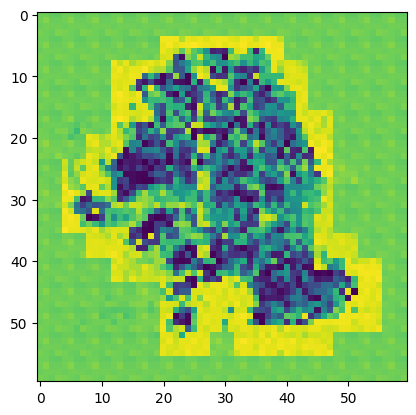

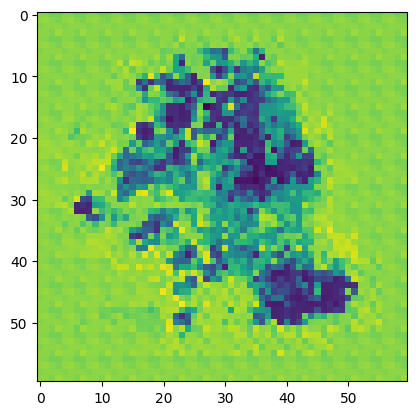

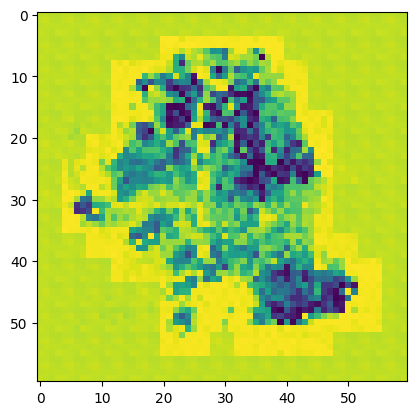

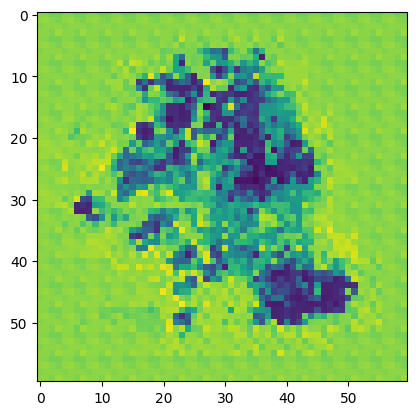

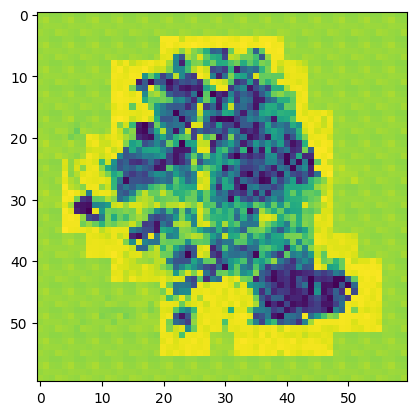

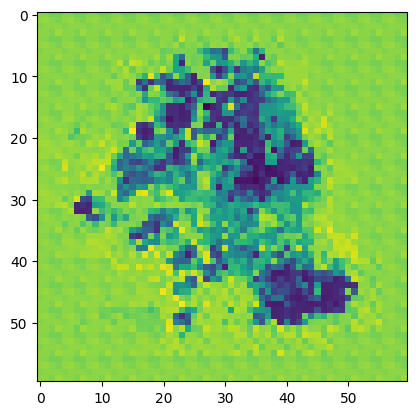

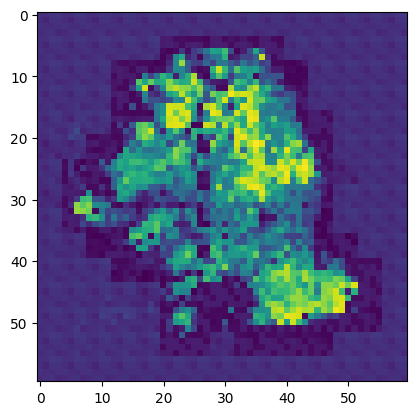

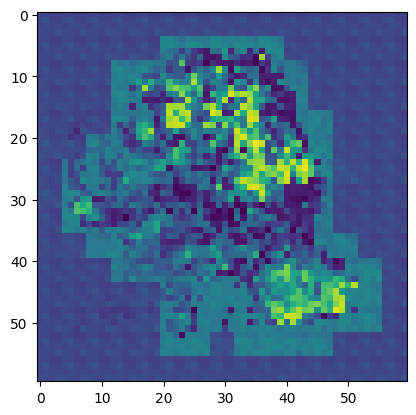

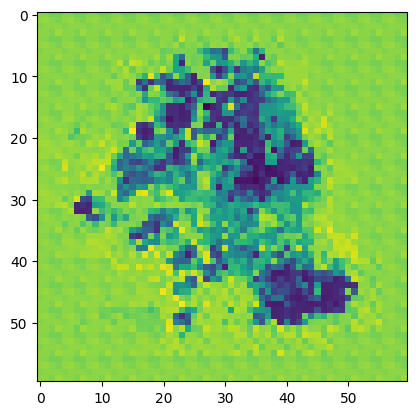

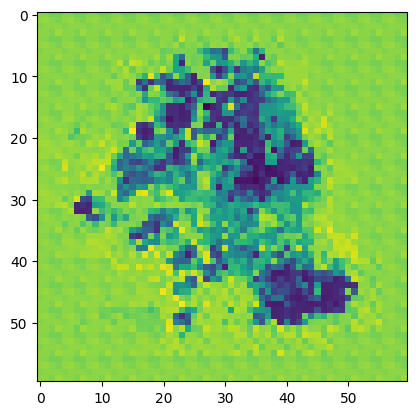

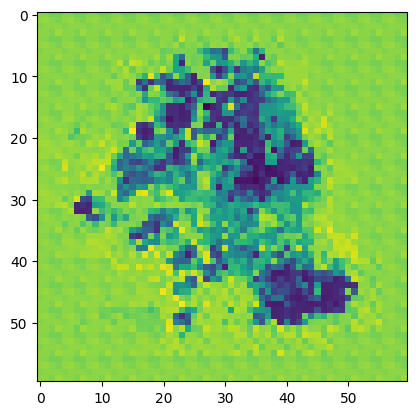

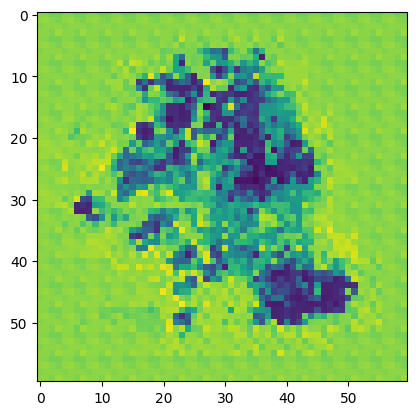

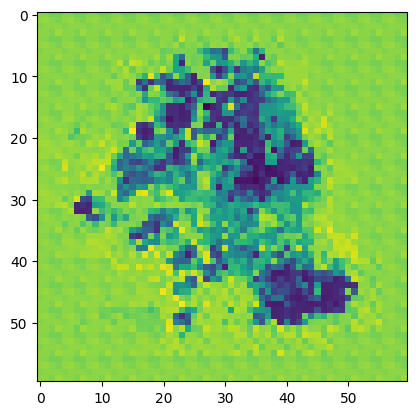

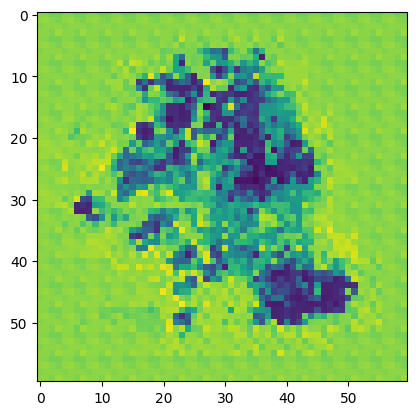

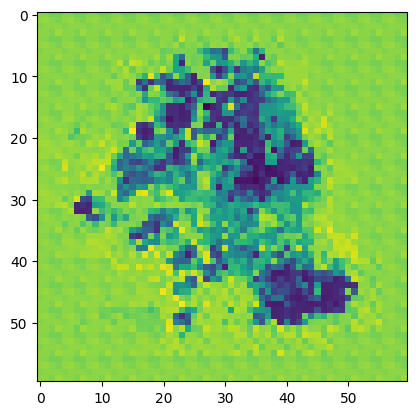

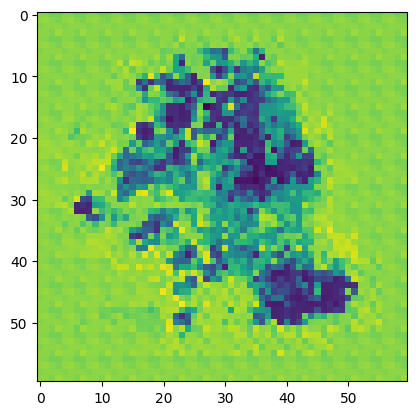

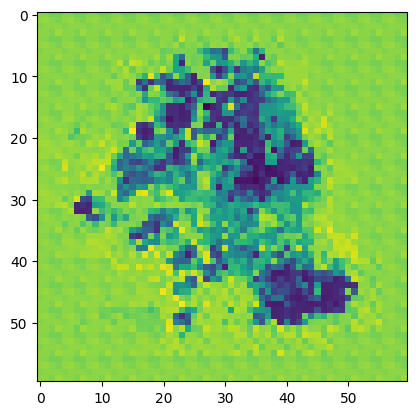

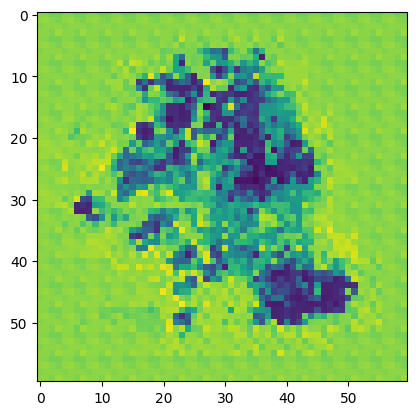

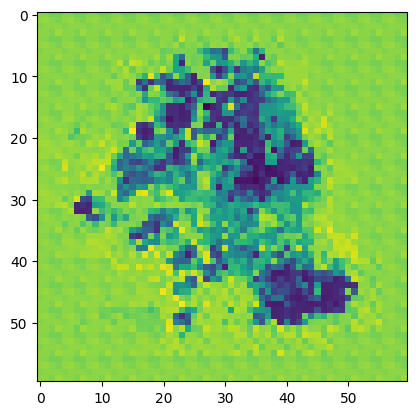

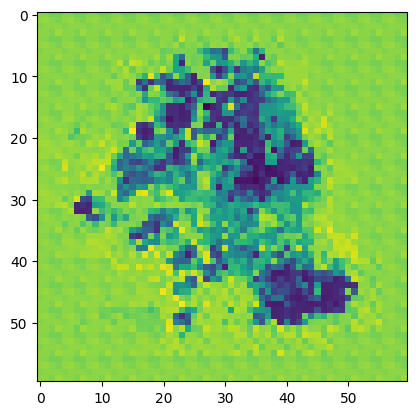

In [20]:
for i in range(20):
    plt.imshow(dists[0, :, :, i])
    plt.show()

In [21]:
# yaml.safe_dump(mushroom_config, open(os.path.join(out_dir, 'mushroom_config.yaml'), 'w'))

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

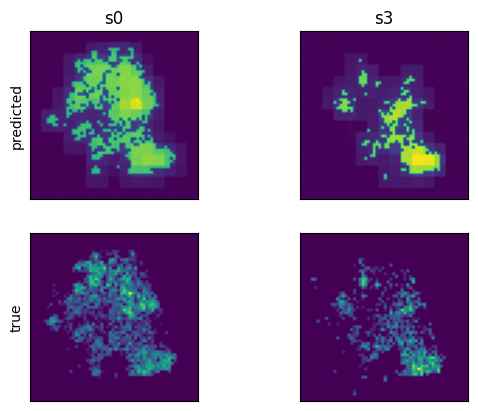

In [22]:
mushroom.display_predicted_pixels(channel='EPCAM')

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

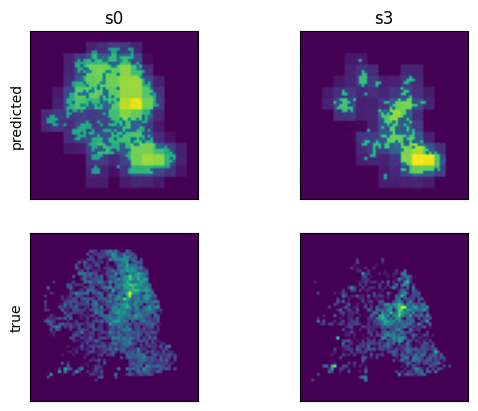

In [23]:
mushroom.display_predicted_pixels(channel='ACTA2')

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

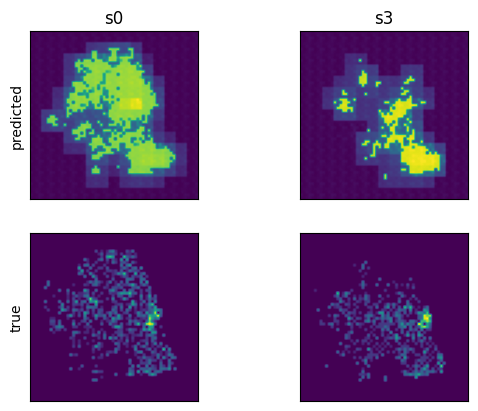

In [24]:
mushroom.display_predicted_pixels(channel='CD68')

In [25]:
mushroom.cluster_sections(margin=.1)

INFO:root:no background channel detected, defaulting to mean of all channels
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/joblib/externals/loky/backend/context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[Errno 13] Permission denied: 'lscpu'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/joblib/externals/loky/backend/context.py", line 250, in _count_physical_cores
    cpu_info = subprocess.run(
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "/data/estorrs/miniconda3/en

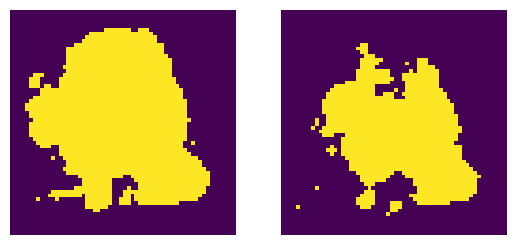

In [26]:
mushroom.clusterer.display_section_masks()

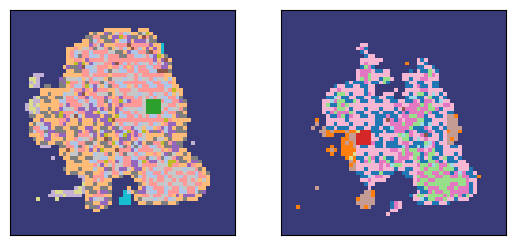

In [27]:
mushroom.clusterer.display_cluster_ids(mushroom.cluster_ids)

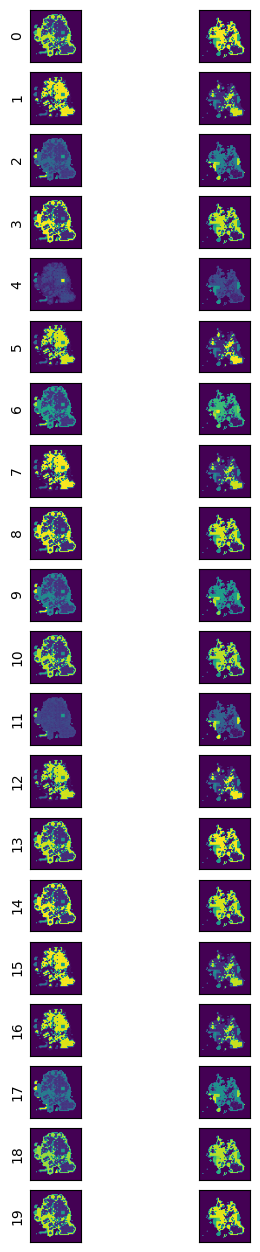

In [28]:
mushroom.clusterer.display_distances(mushroom.dists, figsize=(4, 16))

In [53]:
embs = mushroom.recon_embs.clone().detach().numpy()
embs.shape

(2, 1024, 60, 60)

In [55]:
from einops import rearrange
x = rearrange(embs, 'n d h w -> (n h w) d')
x.shape

(7200, 1024)

In [56]:
from umap import UMAP
u = UMAP(n_components=20)
decomp = u.fit_transform(x)
decomp.shape

(7200, 20)

In [57]:
xx = rearrange(decomp, '(n h w) d -> n d h w', n=2, h=60, w=60)
xx.shape

(2, 20, 60, 60)

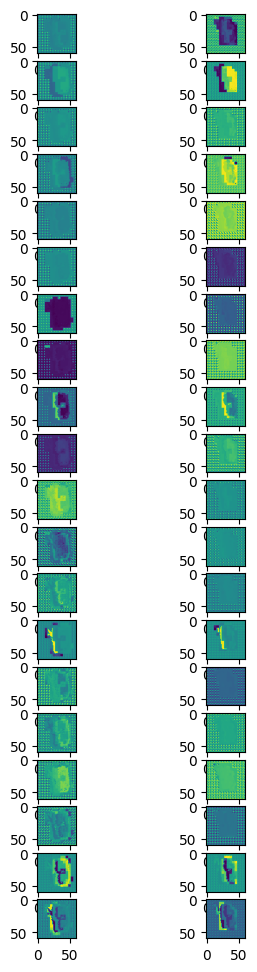

In [61]:
fig, axs = plt.subplots(nrows=xx.shape[1], ncols=xx.shape[0], figsize=(4, 12))
for i in range(xx.shape[1]):
    for j in range(xx.shape[0]):
        ax = axs[i, j]
        ax.imshow(xx[j, i])

In [ ]:
mushroom_config['chkpt_filepath'] = '/data/estorrs/mushroom/data/examples/HT397B1_v1/mushroom_outputs/visium_v2/chkpts/400iter.pt'
mushroom = Mushroom.from_config(mushroom_config)

In [108]:
config = yaml.safe_load(open(config_fps[-3]))
config = visium_to_ome(config)

s0
s0 0 /data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium_processed.h5ad /data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium_processed.ome.tiff
s3
s3 3 /data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium_processed.h5ad /data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium_processed.ome.tiff


In [109]:
config

[{'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium.h5ad'},
   {'dtype': 'visium_ome',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium_processed.ome.tiff'}],
  'id': 's0',
  'position': 0},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s1_multiplex.ome.tiff'}],
  'id': 's1',
  'position': 5},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s2_multiplex.ome.tiff'}],
  'id': 's2',
  'position': 55},
 {'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium.h5ad'},
   {'dtype': 'visium_ome',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium_processed.ome.tiff'}],
  'id': 's3',
  'position': 100},
 {'data': [{'dtype': 'multiplex',
    'filepath